## Introduction
In this notebook we will create and train the classifier on the chest x-ray dataset to classify whether an image shows signs of pneumonia or not

## Imports:

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for all kinds of stuff :)
* matplotlib for visualizing some images



In [22]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [23]:
%pip install -U pytorch-lightning torchmetrics


Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

First we create our dataset.
We can leverage the **DatasetFolder** from torchvision: It allows to simply pass a root directory and return return a dataset object with access to all files within the directory and the directory name as class label. <br />
We only need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as we only have to load our previously stored numpy files.
Additionally, we need to define a list of file extensions (just "npy" in our case).

Finally we can pass a transformation sequence for Data Augmentation and Normalization.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [25]:
def load_file(path):
    return np.load(path).astype(np.float32)

For `Compose`, refer to https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html
<br> For `Normalize`, refer to https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html
<br> For `RandomAffine`, refer to https://pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html


`transform` is `v2` in all the previous examples that we practiced.

In [26]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])



Why are not we doing `RandomAffine` for the `Validation`? ***Ans=>***

Finally, we create the train and val dataset and the corresponding data loaders.

Please adapt batch size and num_workers according to your hardware ressources.

Refer to: https://pytorch.org/vision/main/generated/torchvision.datasets.DatasetFolder.html

torchvision.datasets.DatasetFolder(root: Union[str, Path], ***loader: Callable[[str], Any]***, extensions: Optional[Tuple[str, ...]] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, is_valid_file: Optional[Callable[[str], bool]] = None, allow_empty: bool = False)

In [27]:
train_dataset = torchvision.datasets.DatasetFolder(
    r"C:\Users\zhenu\Desktop\rsna-pneumonia-detection-challenge/Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    r"C:\Users\zhenu\Desktop\rsna-pneumonia-detection-challenge/Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)


Go to the webpage and see what `torchvision.datasets.DatasetFolder` return?

In [28]:
random_index = np.random.randint(0, 20000)
my_output=train_dataset[random_index]
my_output

(tensor([[[-0.4657, -0.4120, -0.3729,  ..., -1.9225, -1.9328, -1.9261],
          [-0.4076, -0.3593, -0.3472,  ..., -1.9143, -1.9162, -1.9150],
          [-0.3996, -0.3646, -0.3568,  ..., -1.9030, -1.9075, -1.9098],
          ...,
          [ 0.4227,  0.4416,  0.4527,  ..., -0.2420, -0.2093, -0.2032],
          [ 0.4414,  0.4771,  0.4878,  ..., -0.2375, -0.2085, -0.2018],
          [ 0.5010,  0.5192,  0.5371,  ..., -0.2068, -0.2085, -0.2018]]]),
 0)

Let's inspect some augmented train images

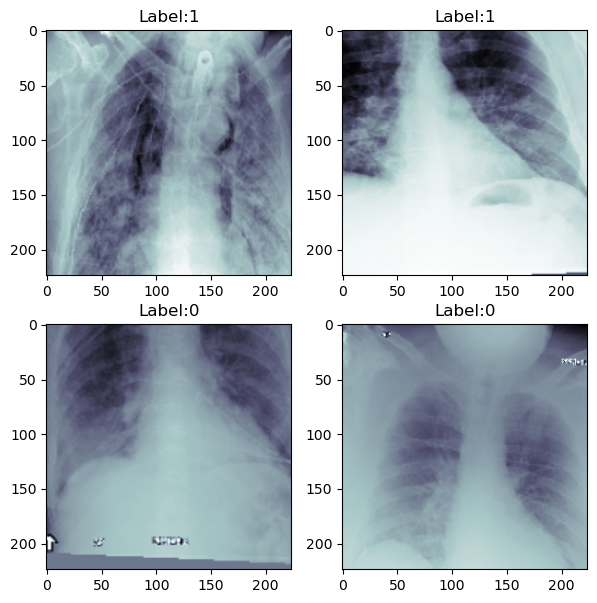

In [29]:
fig, axis = plt.subplots(2, 2, figsize=(7,7))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

Where do we get the label from `train_dataset`? How the program know what is the label. Go ro the `01-Preprocess` and you can see that we only store 2D array, right? But how did that label is inlcuded in the output?

So, we need to design a test to make sure your answer is correct. Write the code for it below. -Hint: multi-Folder idea

To test, we can also use this=> `np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)`

In [30]:
batch_size = 64#TODO
num_workers = 0# TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Oversampling
* Doing nothing :)

In this example, we will simply do nothing as this often yields the best results.
Buf feel free to play around with a weighted loss. A template to define a customized weighted loss function is provided below.

Oversampling will be shown in a later lecture.

In [31]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407], dtype=int64)),
 (array([0, 1]), array([2079,  605], dtype=int64)))

## Model Creation in pytorch lightning

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

=> look at the `starter example`

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, we can use a **training_epoch_end** callback to compute overall dataset statistics and metrics such as accuracy.

Subsequently, we define the **validation_step**. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, we can use **validation_epoch_end** to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Now it is time to create the model** - We will use the ResNet18 network architecture.

Refer to https://www.mathworks.com/help/deeplearning/ref/resnet18.html for descriotion on ResNet18.


***Lets look at all of torchvision models: https://pytorch.org/vision/0.8/models.html*** Now, search for `resnet18` here.

As most of the torchvision models, the original ResNet expects a three channel input in **conv1**. (because of three colors)<br />

However, our X-Ray image data has only one channel.
Thus we need to change the in_channel parameter from 3 to 1.

Additionally, we will change the last fully connected layer to have only one output as we have a binary class label.

### Optimizer and Loss
We use the **Adam** Optimizer with a learning rate of 0.0001 and the **BinaryCrossEntropy** Loss function.<br />
(In fact we use **BCEWithLogitsLoss** which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy).
Feel free to pass a weight different from 1 to the Pneumonia model in order to use the weighted loss function.


In [32]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
from torchmetrics.classification import BinaryAccuracy

class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1.0):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc   = torch.nn.Linear(512, 1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        # keep pos_weight on correct device
        self.register_buffer("pos_weight", torch.tensor([weight], dtype=torch.float32))
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)

        self.train_acc = BinaryAccuracy(threshold=0.5)
        self.val_acc   = BinaryAccuracy(threshold=0.5)

    def forward(self, x):
        return self.model(x)  # (B,1) logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x).squeeze(1)
        loss = self.loss_fn(logits, y)

        probs = torch.sigmoid(logits)
        self.train_acc.update(probs, y.int())

        # v2: prefer unified logging with on_epoch True
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x).squeeze(1)
        loss = self.loss_fn(logits, y)

        probs = torch.sigmoid(logits)
        self.val_acc.update(probs, y.int())

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=x.size(0))
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.val_acc.reset()

    def configure_optimizers(self):
        return self.optimizer


In [34]:
model = PneumoniaModel()  # Instanciate the model

In [35]:
model

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

We create a checkpoint callback which only stores the 10 best models based on the validation accuracy.

In [36]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

In [37]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

#gpus = 0 
#trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
#                     callbacks=checkpoint_callback,
#                     max_epochs=10,
#                     limit_train_batches=20,
#                     limit_val_batches=3)
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",      # <-- must match self.log key
    mode="max",
    save_top_k=10,
    dirpath="checkpoints",
    filename="pneumonia-{epoch:02d}-{val_acc:.3f}"
)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"
devices = 1

trainer = pl.Trainer(
    accelerator=accelerator,
    devices=devices,
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    max_epochs=10,
    limit_train_batches=20,
    limit_val_batches=3
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [38]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\zhenu\.conda\envs\myenv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory A:\UTA\class\AI\08_Pneumonia_Classification\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\zhenu\.conda\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\zhenu\.conda\envs\myenv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric BinaryAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
c:\Users\zhenu\.conda\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Evaluation

Let's evaluate our model!
At first, we load the latest checkpoint and send the model to the GPU, if possible.

In [41]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cuda:0


In [42]:
ckpt_path = checkpoint_callback.best_model_path
print("Best checkpoint:", ckpt_path)

assert ckpt_path and ckpt_path.endswith(".ckpt"), "No checkpoint found — did training finish and save?"
model = PneumoniaModel.load_from_checkpoint(ckpt_path, strict=False, map_location="cpu")
model.to(device).eval()


Best checkpoint: A:\UTA\class\AI\08_Pneumonia_Classification\checkpoints\pneumonia-epoch=00-val_acc=1.000.ckpt


PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Compute prediction on the complete validation set and store predictions and labels

In [43]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2684 [00:00<?, ?it/s]

Compute metrics:
We can see that the overall result is already decent with our simple model.<br />
However, we suffer from a large amount of False Negatives due to the data imbalance.<br />
This is of particular importance in to avoid in medical imaging as missing findings might be fatal.<br />
Feel free to try what happens if you increase or decrease the weight in the loss.

An alternative to retraining with a weighted loss is to reduce the classification threshold from 0.5 to e.g 0.25. It produces way less false negatives but increases the number of False positives. <br />
This is called the precision-recall tradeoff

In [44]:
import torch
from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryConfusionMatrix
)

# Make sure shapes & dtypes are right
preds  = preds.detach().float().view(-1)   # probabilities in [0,1]
labels = labels.detach().int().view(-1)    # 0/1 integers

# Metrics @ 0.5 threshold
acc  = BinaryAccuracy(threshold=0.5)
prec = BinaryPrecision(threshold=0.5)
rec  = BinaryRecall(threshold=0.5)
cm   = BinaryConfusionMatrix(threshold=0.5)

# Confusion matrix @ 0.3 threshold
cm_03 = BinaryConfusionMatrix(threshold=0.3)

print(f"Val Accuracy:  {acc(preds, labels).item():.4f}")
print(f"Val Precision: {prec(preds, labels).item():.4f}")
print(f"Val Recall:    {rec(preds, labels).item():.4f}")
print("Confusion Matrix @0.5:\n", cm(preds, labels).to(torch.int64))
print("Confusion Matrix @0.3:\n", cm_03(preds, labels).to(torch.int64))


Val Accuracy:  0.7738
Val Precision: 0.0000
Val Recall:    0.0000
Confusion Matrix @0.5:
 tensor([[2077,    2],
        [ 605,    0]])
Confusion Matrix @0.3:
 tensor([[1588,  491],
        [ 382,  223]])


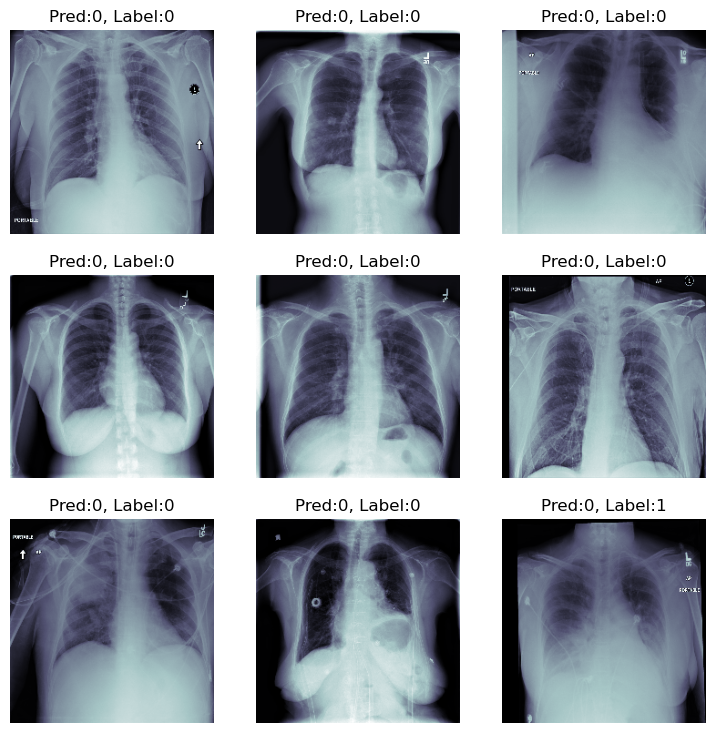

In [45]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


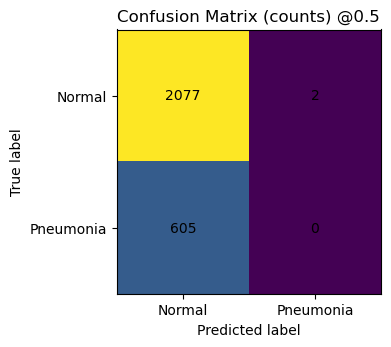

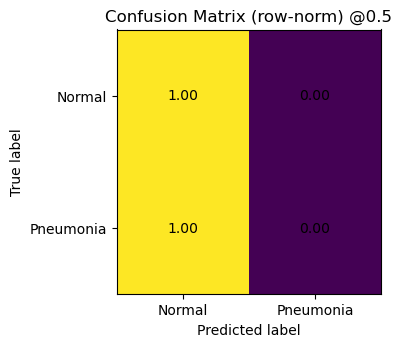

In [46]:
import torch
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryConfusionMatrix

# 0) make hard predictions at your chosen threshold
threshold = 0.5
y_true = labels.cpu().int()
y_pred = (preds >= threshold).cpu().int()

# 1) Confusion matrix (counts)
cm = BinaryConfusionMatrix(threshold=threshold)(preds, labels).cpu().to(torch.int64).numpy()
# cm layout:
# [[TN, FP],
#  [FN, TP]]

# 2) Normalize by true class (rows sum to 1)
cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)

# 3) Plot helper
def plot_cm(cm, title, class_names=("Normal","Pneumonia"), normalize=False, fname=None):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
    ax.set_ylabel("True label"); ax.set_xlabel("Predicted label")

    # annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            txt = f"{val:.2f}" if normalize else f"{val:d}"
            ax.text(j, i, txt, ha="center", va="center")

    fig.tight_layout()
    if fname:
        plt.savefig(fname, bbox_inches="tight", dpi=150)
    plt.show()

plot_cm(cm, "Confusion Matrix (counts) @0.5", fname="cm_counts_val.png")
plot_cm(cm_norm, "Confusion Matrix (row-norm) @0.5", normalize=True, fname="cm_norm_val.png")


In [47]:
import os, json, numpy as np, torch
os.makedirs("eval_artifacts", exist_ok=True)

# If your cm is a torch tensor, convert to numpy
cm_np = cm.cpu().numpy() if isinstance(cm, torch.Tensor) else np.array(cm)

# Save confusion matrix (counts) and a row-normalized version
np.save("eval_artifacts/resnet18_val_cm.npy", cm_np)
np.save("eval_artifacts/resnet18_val_cm_norm.npy", cm_np / cm_np.sum(axis=1, keepdims=True).clip(min=1))

# Save raw preds (probabilities) and labels, in case we want different thresholds later
np.save("eval_artifacts/resnet18_val_probs.npy", np.array(preds.cpu() if torch.is_tensor(preds) else preds))
np.save("eval_artifacts/resnet18_val_labels.npy", np.array(labels.cpu() if torch.is_tensor(labels) else labels))

# (Optional) Save summary metrics you printed earlier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
probs_np = np.load("eval_artifacts/resnet18_val_probs.npy")
labels_np = np.load("eval_artifacts/resnet18_val_labels.npy").astype(int)
metrics = {
    "threshold": 0.5,
    "accuracy": float(accuracy_score(labels_np, (probs_np>=0.5).astype(int))),
    "precision": float(precision_score(labels_np, (probs_np>=0.5).astype(int), zero_division=0)),
    "recall": float(recall_score(labels_np, (probs_np>=0.5).astype(int), zero_division=0)),
    "auc": float(roc_auc_score(labels_np, probs_np)),
}
with open("eval_artifacts/resnet18_val_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved: eval_artifacts/resnet18_val_cm.npy, *_cm_norm.npy, *_probs.npy, *_labels.npy, *_metrics.json")


Saved: eval_artifacts/resnet18_val_cm.npy, *_cm_norm.npy, *_probs.npy, *_labels.npy, *_metrics.json


## 1) The minimal change to the model:

one small architecture change: I add a tiny two-layer head with Dropout before the final logit. This often helps generalization.

So we need to define the new model class (ResNet-18 + dropout head) 


In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision
from torchmetrics.classification import BinaryAccuracy

class PneumoniaModelV2(pl.LightningModule):
    """
    ResNet-18 backbone, small MLP head with Dropout.
    Head: 512 -> 128 (ReLU) -> Dropout(0.3) -> 1 logit
    """
    def __init__(self, pos_weight=1.0, lr=1e-4, wd=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # backbone:
        self.backbone = torchvision.models.resnet18()
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_feats, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, 1)  # single logit
        )

        # loss (class imbalance handled via pos_weight)
        self.register_buffer("pos_weight_buf", torch.tensor([pos_weight], dtype=torch.float32))
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight_buf)

        # metrics
        self.train_acc = BinaryAccuracy(threshold=0.5)
        self.val_acc   = BinaryAccuracy(threshold=0.5)

    def forward(self, x):
        return self.backbone(x)  # (B,1)

    def _shared_step(self, batch, stage):
        x, y = batch
        y = y.float()
        logits = self(x).squeeze(1)
        loss = self.criterion(logits, y)
        probs = torch.sigmoid(logits)

        if stage == "train":
            self.train_acc.update(probs, y.int())
            self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=x.size(0))
            self.log("train_acc",  self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        else:
            self.val_acc.update(probs, y.int())
            self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=x.size(0))
            self.log("val_acc",  self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def on_train_epoch_end(self):
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def on_validation_epoch_end(self):
        self.val_acc.reset()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)


## 2) Instantiate the new model with my dataset’s pos_weight

I need to compute class balance from the existing training set and create PneumoniaModelV2:

In [ ]:
import numpy as np

# Compute pos_weight = (#neg / #pos)
labels_tr = np.array(train_dataset.targets)
neg = (labels_tr == 0).sum()
pos = (labels_tr == 1).sum()
pos_weight_v2 = float(neg / max(pos, 1))
print(f"pos_weight_v2 = {pos_weight_v2:.4f}  (neg={neg}, pos={pos})")

model_v2 = PneumoniaModelV2(pos_weight=pos_weight_v2, lr=1e-4, wd=1e-4)


pos_weight_v2 = 3.4387  (neg=18593, pos=5407)


## 3) Training:

In [ ]:
import os, torch, pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

os.makedirs("checkpoints_v2", exist_ok=True)

checkpoint_cb_v2 = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=3,
    dirpath="checkpoints_v3",
    filename="resnet18_dropout-{epoch:02d}-{val_acc:.3f}"
)

earlystop_cb_v2 = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3
)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"
devices = 1

trainer_v2 = pl.Trainer(
    accelerator=accelerator,
    devices=devices,
    logger=TensorBoardLogger(save_dir="./logs", name="resnet18_dropout"),
    callbacks=[checkpoint_cb_v2, earlystop_cb_v2],
    max_epochs=10,
    num_sanity_val_steps=0
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


## 4) Train the modified model (V2)

Run this cell to fit and capture the best checkpoint path:

In [52]:
# quick sanity check to ensure loaders exist and are non-empty
assert 'train_loader' in globals() and 'val_loader' in globals(), "train_loader/val_loader not found"
assert len(train_dataset) > 0 and len(val_dataset) > 0, "Empty train/val dataset?"

trainer_v2.fit(
    model_v2,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

print("Best ckpt (V2):", checkpoint_cb_v2.best_model_path)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | backbone  | ResNet            | 11.2 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.944    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
c:\Users\zhenu\.conda\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\zhenu\.conda\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\conne

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Best ckpt (V2): A:\UTA\class\AI\08_Pneumonia_Classification\checkpoints_v3\resnet18_dropout-epoch=08-val_acc=0.801.ckpt


## 5) Load best checkpoint, evaluate, and save the confusion matrix (V2)

In [53]:
import torch, numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1) Load best checkpoint for the new model (V2)
ckpt_v2 = checkpoint_cb_v2.best_model_path
print("Best ckpt (V2):", ckpt_v2)
assert ckpt_v2 and ckpt_v2.endswith(".ckpt"), "No V2 checkpoint found."

model_v2_loaded = PneumoniaModelV2.load_from_checkpoint(ckpt_v2, strict=False, map_location="cpu")
model_v2_loaded.to(device).eval()

# 2) Collect probabilities and labels from the VALIDATION loader
pred_probs_v2, labels_v2 = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model_v2_loaded(xb).squeeze(1)
        probs  = torch.sigmoid(logits).cpu().numpy()
        pred_probs_v2.extend(probs.tolist())
        labels_v2.extend(yb.cpu().numpy().tolist())

pred_probs_v2 = np.array(pred_probs_v2)          # shape (N,)
labels_v2     = np.array(labels_v2).astype(int)  # shape (N,)

# 3) Metrics @ threshold=0.5
pred_labels_v2 = (pred_probs_v2 >= 0.5).astype(int)
acc_v2  = accuracy_score(labels_v2, pred_labels_v2)
auc_v2  = roc_auc_score(labels_v2, pred_probs_v2)
cm_v2   = confusion_matrix(labels_v2, pred_labels_v2, labels=[0,1])

print(f"V2 (val) acc: {acc_v2:.4f} | AUC: {auc_v2:.4f}")
print("V2 (val) Confusion Matrix [rows=true, cols=pred]:\n", cm_v2)
print("\nV2 (val) Classification report:\n", classification_report(labels_v2, pred_labels_v2, digits=4))

# 4) Save artifacts for later comparison
import os
os.makedirs("eval_artifacts", exist_ok=True)
np.save("eval_artifacts/resnet18_dropout_val_cm.npy", cm_v2)
np.save("eval_artifacts/resnet18_dropout_val_probs.npy", pred_probs_v2)
np.save("eval_artifacts/resnet18_dropout_val_labels.npy", labels_v2)


Best ckpt (V2): A:\UTA\class\AI\08_Pneumonia_Classification\checkpoints_v3\resnet18_dropout-epoch=08-val_acc=0.801.ckpt
V2 (val) acc: 0.8007 | AUC: 0.8794
V2 (val) Confusion Matrix [rows=true, cols=pred]:
 [[1672  407]
 [ 128  477]]

V2 (val) Classification report:
               precision    recall  f1-score   support

           0     0.9289    0.8042    0.8621      2079
           1     0.5396    0.7884    0.6407       605

    accuracy                         0.8007      2684
   macro avg     0.7342    0.7963    0.7514      2684
weighted avg     0.8411    0.8007    0.8122      2684



## 6) Tune threshold on validation, re-evaluate, and save

In [54]:
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, roc_auc_score, classification_report
import os

# Load what we just saved for V2 (new model)
probs = np.load("eval_artifacts/resnet18_dropout_val_probs.npy")
labels = np.load("eval_artifacts/resnet18_dropout_val_labels.npy").astype(int)

# 1) Pick threshold by best F1 on validation
prec, rec, thr = precision_recall_curve(labels, probs)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
best_thr = thr[max(best_idx - 1, 0)] if len(thr) > 0 else 0.5  # guard if thr empty

print(f"Best threshold by F1: {best_thr:.3f}  (F1={f1[best_idx]:.3f}, P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f})")

# 2) Re-evaluate at tuned threshold
pred_labels_tuned = (probs >= best_thr).astype(int)
cm_v2_tuned = confusion_matrix(labels, pred_labels_tuned, labels=[0, 1])
acc_v2_tuned = accuracy_score(labels, pred_labels_tuned)
auc_v2 = roc_auc_score(labels, probs)  # unchanged by threshold

print(f"\nV2 (val, tuned) acc: {acc_v2_tuned:.4f} | AUC: {auc_v2:.4f} | thr={best_thr:.3f}")
print("V2 (val, tuned) Confusion Matrix [rows=true, cols=pred]:\n", cm_v2_tuned)
print("\nV2 (val, tuned) Classification report:\n", classification_report(labels, pred_labels_tuned, digits=4))

# 3) Save tuned artifacts
os.makedirs("eval_artifacts", exist_ok=True)
np.save("eval_artifacts/resnet18_dropout_val_cm_tuned.npy", cm_v2_tuned)
with open("eval_artifacts/resnet18_dropout_val_threshold.txt", "w") as f:
    f.write(str(best_thr))


Best threshold by F1: 0.545  (F1=0.651, P=0.571, R=0.755)

V2 (val, tuned) acc: 0.8167 | AUC: 0.8794 | thr=0.545
V2 (val, tuned) Confusion Matrix [rows=true, cols=pred]:
 [[1735  344]
 [ 148  457]]

V2 (val, tuned) Classification report:
               precision    recall  f1-score   support

           0     0.9214    0.8345    0.8758      2079
           1     0.5705    0.7554    0.6501       605

    accuracy                         0.8167      2684
   macro avg     0.7460    0.7950    0.7629      2684
weighted avg     0.8423    0.8167    0.8249      2684



## 7) Compare baseline vs new (V2) confusion matrices

Now I load both matrices and display them clearly:

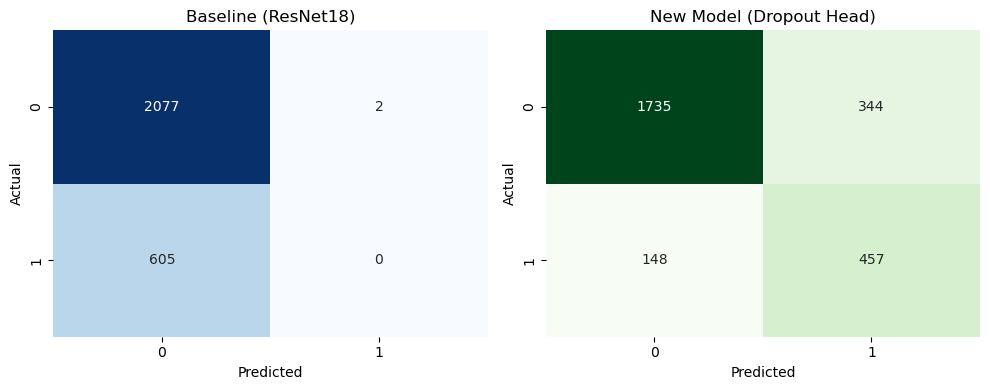

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load both confusion matrices
cm_base = np.load("eval_artifacts/resnet18_val_cm.npy")          # baseline (original model)
cm_v2   = np.load("eval_artifacts/resnet18_dropout_val_cm_tuned.npy")  # new model with dropout head

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axs[0])
axs[0].set_title("Baseline (ResNet18)")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(cm_v2, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axs[1])
axs[1].set_title("New Model (Dropout Head)")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


we can see the bottom-right cell (true positives) increased AND false negatives (bottom-left) decreased.